In [2]:
from giza_datasets import DatasetsLoader
import polars as pl
import os
import certifi
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import onnx
import pandas as pd
import onnxruntime as rt

os.environ["SSL_CERT_FILE"] = certifi.where()

loader = DatasetsLoader()

# Compound V2 Utilization Rate Prediction

## Intro
In this project, our aim is to predict the utilization rate of a given market on Compound V2. In this project, we will focus on USDC. Utilization rate is the ratio between the total amount borrowed and the total amount supplied to a given market (e.g. if 100 USDC is supplied but only 40 USDC is borrowed, the utilization rate is 0.4). Generally, higher utilization rates mean higher fees collected by a lending protocol but also a higher leverage taken by the users, implying higher solvency risk. Additionally, if the utilization rate is too high, some users might not be able to close their positions since there wouldn't be sufficient liquidity to do so.

## Approach
We will use the Compound supply and borrow daily data as well as APYs and TVLs on other protocols to predict our dependent variable. 

## Potential use-cases
- Liquidity Management for multi-chain protocols:
    - Some multi-chain lending protocols provide liquidity on their protocol. If they could predict the utilization rate on each chain, they could re-distribute their liquidity between the chains. That could serve multiple purpose, ranging from maintaining sufficient levels of liquidity on all chains or optimizing the utilization rate across the instances of the protocol. 

In [56]:
apy_df = loader.load("top-pools-apy-per-protocol")
tvl_df = loader.load("tvl-per-project-tokens")
compound_df = loader.load("compound-daily-interest-rates")

In [57]:
import gcsfs
import polars as pl

fs = gcsfs.GCSFileSystem(verify=False)
mcap_path = "gs://datasets-giza/tokens_daily_prices_mcap_volume/tokens_daily_prices_mcap_volume.parquet"
with fs.open(mcap_path) as f:
    mcap_df = pl.read_parquet(f, use_pyarrow=True)

In [50]:
mcap_df.head()

date,price,market_cap,volumes_last_24h,token
date,f64,f64,f64,str
2019-02-01,3438.360403,0.0,20589.040403,"""WBTC"""
2019-02-02,3472.243307,0.0,12576.723906,"""WBTC"""
2019-02-03,3461.058341,0.0,1852.526033,"""WBTC"""
2019-02-04,3468.16004,0.0,7029.292885,"""WBTC"""
2019-02-05,3476.127865,0.0,3544.645877,"""WBTC"""


In [34]:
compound_df.head()

symbol,totalBorrows,borrowRate,totalSupply,supplyRate,underlyingPriceUSD,exchangeRate,timestamp,block_number,totalSupplyUnderlying,totalSupplyUSD,totalBorrowUSD
str,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64
"""cREP""",1.0,0.039471,770.37388,0.002306,20.004143,0.02,1557273600,7716767,15.407478,308.213387,20.004143
"""cUSDC""",100.000061,0.016183,61792.477811,0.001179,1.0,0.02,1557273600,7716767,1235.849612,1235.849612,100.000061
"""cETH""",1.000347,0.012274,815.024663,0.000678,171.043415,0.02,1557273600,7716767,16.30056,2788.103472,171.102775
"""cBAT""",202.004561,0.033222,229166.032891,0.001318,0.335843,0.02,1557273600,7716767,4583.324763,1539.279082,67.841886
"""cZRX""",100.001725,0.054585,43371.739085,0.005664,0.276315,0.02,1557273600,7716767,867.436335,239.685813,27.631993


In [58]:
# remove the "c" value indicating the receipt token from the symbol column in compound dataframe
compound_df = compound_df.with_columns(
    [compound_df["symbol"].map_elements(lambda value: value[1:]).alias("symbol")]
)

# create the date column
compound_df = compound_df.with_columns(
    (pl.col("timestamp") * 1000000)
    .cast(pl.Datetime)
    .dt.strftime("%Y-%m-%d")
    .alias("date")
)

min_comp_dt = compound_df.select(pl.min("date")).to_numpy()[0, 0]

In [59]:
# checking if all token symbols are uppercased
for token in apy_df["underlying_token"].unique():
    if token != token.upper():
        print("apy", token)

for token in compound_df["symbol"].unique():
    if token != token.upper():
        print("compound", token)

for token in mcap_df["token"].unique():
    if token != token.upper():
        print("mcap", token)

In [60]:
# filter out for only the assets present in compound
comp_assets = list(compound_df["symbol"].unique())

apy_df = apy_df.filter(apy_df["underlying_token"].is_in(comp_assets))
# aave_df = aave_df.filter(aave_df["symbol"].is_in(comp_assets))
# prices_df = prices_df.filter(prices_df["token"].is_in(comp_assets))
mcap_df = mcap_df.filter(mcap_df["token"].is_in(comp_assets))


# for tvl dataset we need to take a couple more steps
# first, let's change the wide format to long format
tvl_df = tvl_df.melt(id_vars=["date", "project"])
tvl_df = tvl_df.rename({"variable": "symbol", "value": "tvl"})
# nulls
tvl_df = tvl_df.drop_nulls()

# finally, filter for compound assets
tvl_df = tvl_df.filter(tvl_df["symbol"].is_in(comp_assets))

In [61]:
# rename all to symbol
apy_df = apy_df.rename({"underlying_token": "symbol"})
mcap_df = mcap_df.rename({"token": "symbol"})

In [62]:
missing_assets = {
    "apy_df": [],
    "tvl_df": [],
    "mcap_df": [],
}
for asset in comp_assets:
    if asset not in apy_df["symbol"].unique():
        missing_assets["apy_df"].append(asset)

    if asset not in tvl_df["symbol"].unique():
        missing_assets["tvl_df"].append(asset)

    if asset not in mcap_df["symbol"].unique():
        missing_assets["mcap_df"].append(asset)

print(missing_assets)

{'apy_df': ['REP', 'USDP', 'FEI'], 'tvl_df': ['REP'], 'mcap_df': ['REP', 'USDP', 'FEI']}


In [65]:
# we will remove the tokens that are missing in most/all dataframes and drop the aave_df altogether
comp_assets.remove("USDP")
comp_assets.remove("REP")
comp_assets.remove("FEI")

apy_df = apy_df.filter(apy_df["symbol"].is_in(comp_assets))
tvl_df = tvl_df.filter(tvl_df["symbol"].is_in(comp_assets))
mcap_df = mcap_df.filter(mcap_df["symbol"].is_in(comp_assets))
# prices_df = prices_df.filter(prices_df["symbol"].is_in(comp_assets))
# volume_df = volume_df.filter(volume_df["symbol"].is_in(comp_assets))
compound_df = compound_df.filter(compound_df["symbol"].is_in(comp_assets))

In [66]:
# filter out for biggest protocols
tvl_filter_protocols = [
    "yearn-finance",
    "aave-v2",
    "sushiswap",
    "aave-v3",
    "uniswap-v3",
    "curve-dex",
    "uniswap-v2",
    "balancer-v2",
]
apy_filter_protocols = ["yearn-finance", "spark", "aave-v3", "aave-v2", "thorchain"]

tvl_df = tvl_df.filter(tvl_df["project"].is_in(tvl_filter_protocols))
apy_df = apy_df.filter(apy_df["project"].is_in(apy_filter_protocols))

In [67]:
apy_df["chain"].value_counts()
# other chains have relatively few entries so reducing dimensionality (avoiding adding one-hot-encoded columns)
apy_df = apy_df.filter(apy_df["chain"].is_in(['Ethereum']))
apy_df = apy_df.drop("chain")

In [68]:
# for both APY and TVL statistics, we will be interested in the means/totals across multiple protocols
# this is mainly to avoid intriducing too many features, resulting in the curse of dimensionality
# for APYs, we will take a tvl-weighted average across protocols per day for each token
# for TVLs, we will take a total tvl across protocols per day for each token


# Define the weighted mean using polars expressions
def weighted_mean(apy: pl.Expr, tvlUsd: pl.Expr) -> pl.Expr:
    return (apy * tvlUsd).sum() / tvlUsd.sum()


# Group by 'date' and 'symbol', then calculate the weighted mean for 'apy'
apy_df = apy_df.groupby(["date", "symbol"]).agg(
    weighted_mean(pl.col("apy"), pl.col("tvlUsd")).alias("mean_apy")
)
apy_df = apy_df.pivot(index="date", columns="symbol", values="mean_apy")
apy_df = apy_df.sort("date")

# check if we don't have any missing days
min_date = apy_df.select(pl.min("date")).to_numpy()[0, 0]
max_date = apy_df.select(pl.max("date")).to_numpy()[0, 0]
difference = (max_date - min_date).astype(int)
assert len(apy_df) >= difference

# Create an expression to count nulls for each column
null_counts = [
    pl.col(column).is_null().sum().alias(column)
    for column in apy_df.columns
    if column != "date"
]

# Apply the expressions to the DataFrame and collect the result
null_count_df = apy_df.select(null_counts)

# Display the count of null values for each column
print(null_count_df)

shape: (1, 8)
┌──────┬──────┬──────┬─────┬──────┬──────┬─────┬─────┐
│ WBTC ┆ USDT ┆ USDC ┆ DAI ┆ AAVE ┆ LINK ┆ ETH ┆ YFI │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---  ┆ ---  ┆ --- ┆ --- │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32  ┆ u32  ┆ u32 ┆ u32 │
╞══════╪══════╪══════╪═════╪══════╪══════╪═════╪═════╡
│ 0    ┆ 0    ┆ 0    ┆ 1   ┆ 0    ┆ 0    ┆ 604 ┆ 52  │
└──────┴──────┴──────┴─────┴──────┴──────┴─────┴─────┘


/var/folders/zb/xt8wb2n148d77wtngx9bhgb40000gn/T/ipykernel_95464/1082657515.py:13: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  apy_df = apy_df.groupby(["date", "symbol"]).agg(


In [69]:
# we have too many nulls for ETH so we will remove it completely
# for DAI and YFI, we will fill the nulls with the previous value

apy_df = apy_df.drop("ETH")

# Step 1: Forward Fill - Fill nulls with the last observed non-null value
apy_df = apy_df.with_columns(apy_df["YFI"].fill_null(strategy="forward").alias("YFI"))
apy_df = apy_df.with_columns(apy_df["DAI"].fill_null(strategy="forward").alias("DAI"))

# Step 2: Backward Fill - Fill any remaining nulls with the next observed non-null value
apy_df = apy_df.with_columns(apy_df["YFI"].fill_null(strategy="backward").alias("YFI"))
apy_df.head()

date,WBTC,USDT,USDC,DAI,AAVE,LINK,YFI
date,f64,f64,f64,f64,f64,f64,f64
2022-02-11,0.00656,2.05082,2.0951,2.2472,0.0,0.94,0.0
2022-02-12,0.00635,2.01914,1.90504,2.21331,0.0,0.94,0.0
2022-02-13,0.00631,1.99941,1.80437,2.21811,0.0,0.94,0.0
2022-02-14,0.0065,1.98619,1.79514,2.22086,0.0,0.94,0.0
2022-02-15,0.00673,1.94523,1.8259,2.22212,0.0,0.94,0.0


In [70]:
# for TVLs, we will take a total tvl across protocols per day for each token
tvl_df = tvl_df.group_by(["date", "symbol"]).agg(pl.col("tvl").sum().alias("total_tvl"))

tvl_df = tvl_df.pivot(index="date", columns="symbol", values="total_tvl")
tvl_df = tvl_df.sort("date")

# check if we don't have any missing days
min_date = tvl_df.select(pl.min("date")).to_numpy()[0, 0]
max_date = tvl_df.select(pl.max("date")).to_numpy()[0, 0]
difference = (max_date - min_date).astype(int)
assert len(tvl_df) >= difference

In [71]:
# Create an expression to count nulls for each column
null_counts = [
    pl.col(column).is_null().sum().alias(column)
    for column in tvl_df.columns
    if column != "date"
]

# Apply the expressions to the DataFrame and collect the result
null_count_df = tvl_df.select(null_counts)

# Display the count of null values for each column
print(null_count_df)

shape: (1, 14)
┌──────┬─────┬─────┬──────┬───┬─────┬─────┬─────┬──────┐
│ AAVE ┆ BAT ┆ DAI ┆ LINK ┆ … ┆ YFI ┆ ZRX ┆ ETH ┆ COMP │
│ ---  ┆ --- ┆ --- ┆ ---  ┆   ┆ --- ┆ --- ┆ --- ┆ ---  │
│ u32  ┆ u32 ┆ u32 ┆ u32  ┆   ┆ u32 ┆ u32 ┆ u32 ┆ u32  │
╞══════╪═════╪═════╪══════╪═══╪═════╪═════╪═════╪══════╡
│ 296  ┆ 296 ┆ 296 ┆ 296  ┆ … ┆ 296 ┆ 296 ┆ 642 ┆ 450  │
└──────┴─────┴─────┴──────┴───┴─────┴─────┴─────┴──────┘


In [72]:
# seems like USDT has more non-empty rows than all other tokens
# let's remove the additional USDT values so that we don't have to fill almost an entire year's worht of data artificilally, thus introducing unnecesary noise

# Find the index of the first non-null value in AAVE column (it has the same number of nulls as most others)
first_non_null_index = (
    tvl_df.with_row_count().filter(pl.col("AAVE").is_not_null())["row_nr"].gather([0])
)[0]

tvl_df = tvl_df.slice(first_non_null_index, tvl_df.height - first_non_null_index)

tvl_df = tvl_df.drop("ETH")


def back_forward_fill(df):
    for token in df.columns:
        if token != "date":
            # Step 1: Forward Fill - Fill nulls with the last observed non-null value
            df = df.with_columns(df[token].fill_null(strategy="forward").alias(token))
            # Step 2: Backward Fill - Fill any remaining nulls with the next observed non-null value
            df = df.with_columns(df[token].fill_null(strategy="backward").alias(token))

    return df


tvl_df = back_forward_fill(tvl_df)

In [73]:
# Convert your string date to a Polars date for comparison
min_comp_dt_pl = pl.lit(min_comp_dt).str.strptime(pl.Date, "%Y-%m-%d")

# Filter for rows where 'date' is greater than 'my_date'
tvl_df = tvl_df.filter(tvl_df["date"] >= min_comp_dt_pl)

In [80]:
price_df = mcap_df.select(["date", "price", "symbol"])
price_df = price_df.pivot(index="date", columns="symbol", values="price")
price_df = price_df.sort("date")
price_df = price_df.filter(price_df["date"] >= min_comp_dt_pl)
# check if we don't have any missing days
min_date = price_df.select(pl.min("date")).to_numpy()[0, 0]
max_date = price_df.select(pl.max("date")).to_numpy()[0, 0]
difference = (max_date - min_date).astype(int)
assert len(price_df) >= difference

vol_df = mcap_df.select(["date", "volumes_last_24h", "symbol"])
vol_df = vol_df.pivot(index="date", columns="symbol", values="volumes_last_24h")
vol_df = vol_df.sort("date")
vol_df = vol_df.filter(vol_df["date"] >= min_comp_dt_pl)
# check if we don't have any missing days
min_date = vol_df.select(pl.min("date")).to_numpy()[0, 0]
max_date = vol_df.select(pl.max("date")).to_numpy()[0, 0]
difference = (max_date - min_date).astype(int)
assert len(vol_df) >= difference

mcap_df = mcap_df.select(["date", "market_cap", "symbol"])
mcap_df = mcap_df.pivot(index="date", columns="symbol", values="market_cap")
mcap_df = mcap_df.sort("date")
mcap_df = mcap_df.filter(mcap_df["date"] >= min_comp_dt_pl)
# check if we don't have any missing days
min_date = mcap_df.select(pl.min("date")).to_numpy()[0, 0]
max_date = mcap_df.select(pl.max("date")).to_numpy()[0, 0]
difference = (max_date - min_date).astype(int)
assert len(mcap_df) >= difference

In [84]:
# Create an expression to count nulls for each column
null_counts = [
    pl.col(column).is_null().sum().alias(column)
    for column in price_df.columns
    if column != "date"
]

# Apply the expressions to the DataFrame and collect the result
null_count_df = price_df.select(null_counts)

# Display the count of null values for each column
null_count_df.head()

WBTC,USDC,USDT,DAI,LINK,AAVE,ETH,YFI,UNI,COMP,TUSD,BAT,SUSHI,ZRX
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,1,195,0,514,0,437,498,405,0,0,478,0


In [94]:
price_df = back_forward_fill(price_df)
vol_df = back_forward_fill(vol_df)
mcap_df = back_forward_fill(mcap_df)

In [95]:
prices_tokens = list(price_df.columns)
prices_tokens.remove("date")

for token in prices_tokens:
    # Calculate log returns
    log_returns = pl.col(token) / pl.col(token).shift(1)
    log_returns = log_returns.map_elements(
        lambda x: np.log(x) if x is not None else None
    ).alias(token + "_logreturn")

    # Add the log returns column to the DataFrame
    price_df = price_df.with_columns(log_returns)

window_size = 7  # 1 week rolling std

for token in prices_tokens:
    vol = price_df.select(
        pl.col(token + "_logreturn")
        .rolling_std(window_size)
        .alias(token + "_volatility")
    )
    price_df = price_df.with_columns(vol)
    price_df = price_df.drop(token)

In [98]:
# rename columns before merging
for token in apy_df.columns:
    if token != "date":
        apy_df = apy_df.rename({token: token + "_apy"})

for token in tvl_df.columns:
    if token != "date":
        tvl_df = tvl_df.rename({token: token + "_tvl"})

for token in vol_df.columns:
    if token != "date":
        vol_df = vol_df.rename({token: token + "_volume"})

for token in mcap_df.columns:
    if token != "date":
        mcap_df = mcap_df.rename({token: token + "_mcap"})

In [99]:
# prepare the compound table before merging
compound_df = compound_df.drop("underlyingPriceUSD")
compound_df = compound_df.drop("exchangeRate")
compound_df = compound_df.drop("timestamp")
compound_df = compound_df.drop("block_number")
compound_df = compound_df.drop("totalSupply")
compound_df = compound_df.drop("totalSupplyUSD")
compound_df = compound_df.drop("totalBorrowUSD")

In [127]:
compound_df = compound_df.group_by(["date", "symbol"]).agg(
    [
        pl.col("totalBorrows").sum().alias("totalBorrows"),
        pl.col("totalSupplyUnderlying").sum().alias("totalSupply"),
        # Weighted mean for borrowRate
        (
            (pl.col("borrowRate") * pl.col("totalBorrows")).sum()
            / pl.col("totalBorrows").sum()
        ).alias("borrowRate"),
        # Weighted mean for supplyRate
        (
            (pl.col("supplyRate") * pl.col("totalSupplyUnderlying")).sum()
            / pl.col("totalSupplyUnderlying").sum()
        ).alias("supplyRate"),
    ]
)

compound_df = compound_df.with_columns(
    (pl.col("totalBorrows") / pl.col("totalSupply")).alias("utilization_rate")
)

/var/folders/zb/xt8wb2n148d77wtngx9bhgb40000gn/T/ipykernel_95464/47724883.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  compound_df = compound_df.groupby(["date", "symbol"]).agg(


In [132]:
# during the exploration we noticed that there are some rows that are not unique
# for the same combination of 'date' and 'symbol'
# this comes from the fact that compound v2 was operating two markets simultaneously for wbtc and dai
# these were for slightly different versions of the underlying tokens, e.g. discussed here: https://www.comp.xyz/t/seize-all-cwbtc-legacy-collateral-and-transfer-its-wbtc-it-to-cwbtc2/1829
# for the sake of this analysis, we will aggregate those duplicated rows

# Define the metrics you want to pivot on
metrics = [
    "totalBorrows",
    "borrowRate",
    "supplyRate",
    "totalSupply",
    "utilization_rate",
]

# Initialize a DataFrame to store the pivoted result for the first metric
comp_grouped_df = compound_df.select(["date", "symbol"]).unique()

# Loop through each metric, pivot the DataFrame, rename columns, and join the results
for metric in metrics:
    # Pivot the DataFrame
    pivoted_df = compound_df.pivot(index="date", columns="symbol", values=metric)

    # Rename columns to include the metric as a suffix, except for the 'date' column
    renamed_columns = {
        col: f"{col}_{metric}" for col in pivoted_df.columns if col != "date"
    }
    pivoted_df = pivoted_df.rename(renamed_columns)

    # Join the pivoted DataFrame with the final DataFrame on 'date'
    comp_grouped_df = comp_grouped_df.join(pivoted_df, on="date", how="outer")
    comp_grouped_df = comp_grouped_df.drop("date_right")

comp_grouped_df = comp_grouped_df.drop("symbol")
comp_grouped_df = comp_grouped_df.sort("date")
comp_grouped_df = comp_grouped_df.unique()
# Display the final DataFrame
comp_grouped_df.head()

date,BAT_totalBorrows,ETH_totalBorrows,DAI_totalBorrows,USDC_totalBorrows,ZRX_totalBorrows,WBTC_totalBorrows,USDT_totalBorrows,COMP_totalBorrows,UNI_totalBorrows,LINK_totalBorrows,TUSD_totalBorrows,SUSHI_totalBorrows,AAVE_totalBorrows,YFI_totalBorrows,BAT_borrowRate,ETH_borrowRate,DAI_borrowRate,USDC_borrowRate,ZRX_borrowRate,WBTC_borrowRate,USDT_borrowRate,COMP_borrowRate,UNI_borrowRate,LINK_borrowRate,TUSD_borrowRate,SUSHI_borrowRate,AAVE_borrowRate,YFI_borrowRate,BAT_supplyRate,ETH_supplyRate,DAI_supplyRate,USDC_supplyRate,ZRX_supplyRate,WBTC_supplyRate,USDT_supplyRate,COMP_supplyRate,UNI_supplyRate,LINK_supplyRate,TUSD_supplyRate,SUSHI_supplyRate,AAVE_supplyRate,YFI_supplyRate,BAT_totalSupply,ETH_totalSupply,DAI_totalSupply,USDC_totalSupply,ZRX_totalSupply,WBTC_totalSupply,USDT_totalSupply,COMP_totalSupply,UNI_totalSupply,LINK_totalSupply,TUSD_totalSupply,SUSHI_totalSupply,AAVE_totalSupply,YFI_totalSupply,BAT_utilization_rate,ETH_utilization_rate,DAI_utilization_rate,USDC_utilization_rate,ZRX_utilization_rate,WBTC_utilization_rate,USDT_utilization_rate,COMP_utilization_rate,UNI_utilization_rate,LINK_utilization_rate,TUSD_utilization_rate,SUSHI_utilization_rate,AAVE_utilization_rate,YFI_utilization_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2019-05-12""",202.075884,9.005818,1832.283809,2401.636267,100.001725,null,null,null,null,null,null,null,null,null,0.033227,0.044995,0.090408,0.110226,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.00911,0.0274,0.054676,0.005664,null,null,null,null,null,null,null,null,null,4583.389175,40.030116,5441.192492,4357.49602,867.436335,null,null,null,null,null,null,null,null,null,0.044089,0.224976,0.336743,0.551151,0.115284,null,null,null,null,null,null,null,null,null
"""2019-05-18""",5202.687152,16.511554,2273.809271,3002.968384,100.163478,null,null,null,null,null,null,null,null,null,0.189431,0.04458,0.092387,0.077012,0.044985,null,null,null,null,null,null,null,null,null,0.096287,0.008943,0.029373,0.026692,0.003372,null,null,null,null,null,null,null,null,null,9211.988233,74.074469,6436.738615,7797.837106,1202.653133,null,null,null,null,null,null,null,null,null,0.564774,0.222905,0.353255,0.385103,0.083285,null,null,null,null,null,null,null,null,null
"""2019-05-25""",33361.757831,601.406044,2.1019e6,60442.094221,10086.586249,null,null,null,null,null,null,null,null,null,0.023295,0.003513,0.136827,0.082576,0.048083,null,null,null,null,null,null,null,null,null,0.00023,0.000056,0.089105,0.030685,0.004051,null,null,null,null,null,null,null,null,null,3.0378e6,34235.007524,2.9049e6,146388.071904,107749.464801,null,null,null,null,null,null,null,null,null,0.010982,0.017567,0.723579,0.412889,0.093611,null,null,null,null,null,null,null,null,null
"""2019-05-26""",33364.161233,653.24962,3.1780e6,99907.673773,10087.983116,null,null,null,null,null,null,null,null,null,0.023227,0.003441,0.156781,0.087703,0.030742,null,null,null,null,null,null,null,null,null,0.000225,0.000053,0.125567,0.034614,0.000991,null,null,null,null,null,null,null,null,null,3.1022e6,37970.0173,3.5713e6,227827.569166,281724.388978,null,null,null,null,null,null,null,null,null,0.010755,0.017204,0.889895,0.438523,0.035808,null,null,null,null,null,null,null,null,null
"""2019-06-03""",305624.6609,1849.116423,5.3470e6,457531.136797,240978.088503,null,null,null,null,null,null,null,null,null,0.04592,0.029507,0.139748,0.116858,0.048713,null,null,null,null,null,null,null,null,null,0.003571,0.000842,0.094092,0.061457,0.004196,null,null,null,null,null,null,null,null,null,3.5374e6,58347.023675,7.1474e6,782976.91247,2.5178e6,null,null,null,null,null,null,null,null,null,0.086399,0.031692,0.748107,0.584348,0.095711,null,null,null,null,null,null,null,null,null


In [143]:
comp_grouped_df = comp_grouped_df.with_columns(
    (pl.col("date").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))
)

final_df = comp_grouped_df.join(apy_df, on="date", how="outer")
final_df = final_df.drop("date_right")
final_df = final_df.join(tvl_df, on="date", how="outer")
final_df = final_df.drop("date_right")
final_df = final_df.join(vol_df, on="date", how="outer")
final_df = final_df.drop("date_right")
final_df = final_df.join(mcap_df, on="date", how="outer")
final_df = final_df.drop("date_right")
final_df = final_df.join(price_df, on="date", how="outer")
final_df = final_df.drop("date_right")
final_df = final_df.filter(pl.col("date").is_not_null())
final_df.head()

date,BAT_totalBorrows,ETH_totalBorrows,DAI_totalBorrows,USDC_totalBorrows,ZRX_totalBorrows,WBTC_totalBorrows,USDT_totalBorrows,COMP_totalBorrows,UNI_totalBorrows,LINK_totalBorrows,TUSD_totalBorrows,SUSHI_totalBorrows,AAVE_totalBorrows,YFI_totalBorrows,BAT_borrowRate,ETH_borrowRate,DAI_borrowRate,USDC_borrowRate,ZRX_borrowRate,WBTC_borrowRate,USDT_borrowRate,COMP_borrowRate,UNI_borrowRate,LINK_borrowRate,TUSD_borrowRate,SUSHI_borrowRate,AAVE_borrowRate,YFI_borrowRate,BAT_supplyRate,ETH_supplyRate,DAI_supplyRate,USDC_supplyRate,ZRX_supplyRate,WBTC_supplyRate,USDT_supplyRate,COMP_supplyRate,…,ETH_mcap,YFI_mcap,UNI_mcap,COMP_mcap,TUSD_mcap,BAT_mcap,SUSHI_mcap,ZRX_mcap,date_right,WBTC_logreturn,USDC_logreturn,USDT_logreturn,DAI_logreturn,LINK_logreturn,AAVE_logreturn,ETH_logreturn,YFI_logreturn,UNI_logreturn,COMP_logreturn,TUSD_logreturn,BAT_logreturn,SUSHI_logreturn,ZRX_logreturn,WBTC_volatility,USDC_volatility,USDT_volatility,DAI_volatility,LINK_volatility,AAVE_volatility,ETH_volatility,YFI_volatility,UNI_volatility,COMP_volatility,TUSD_volatility,BAT_volatility,SUSHI_volatility,ZRX_volatility
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2019-05-08,202.004561,1.000347,200.005118,100.000061,100.001725,null,null,null,null,null,null,null,null,null,0.033222,0.012274,0.055964,0.016183,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.000678,0.002503,0.001179,0.005664,null,null,null,…,1.8165e10,1.5978e6,2.1991e8,0.0,2.3037e8,4.0226e8,6.1224e6,1.5702e8,2019-05-08,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2019-05-09,202.037785,9.00187,1702.157256,1400.546701,100.001725,null,null,null,null,null,null,null,null,null,0.033224,0.051584,0.086578,0.1879,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.011974,0.023751,0.158885,0.005664,null,null,null,…,1.8006e10,1.5978e6,2.1991e8,0.0,2.3168e8,3.9536e8,6.1224e6,1.6017e8,2019-05-09,0.043385,-0.001417,0.003759,0.0,0.059884,0.0,0.000087,0.0,0.0,0.0,0.005349,-0.013501,0.0,0.019011,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2019-05-10,202.054531,9.003197,1832.126395,2401.465977,100.001725,null,null,null,null,null,null,null,null,null,0.033225,0.045012,0.090455,0.110072,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.009117,0.027445,0.054524,0.005664,null,null,null,…,1.8116e10,1.5978e6,2.1991e8,0.0,2.3467e8,3.5546e8,6.1224e6,1.5040e8,2019-05-10,0.012184,0.000911,0.001509,0.0,0.077551,0.0,0.002729,0.0,0.0,0.0,0.002114,-0.101955,0.0,-0.062552,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2019-05-11,202.075884,9.003197,1831.947502,2401.636267,100.001725,null,null,null,null,null,null,null,null,null,0.033227,0.045012,0.090515,0.110226,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.009117,0.027505,0.054676,0.005664,null,null,null,…,1.8290e10,1.5978e6,2.1991e8,0.0,2.3527e8,4.5541e8,6.1224e6,1.5658e8,2019-05-11,0.027829,-0.000284,0.001068,0.0,0.058696,0.0,0.012274,0.0,0.0,0.0,-0.001367,0.240266,0.0,0.042285,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2019-05-12,202.075884,9.005818,1832.283809,2401.636267,100.001725,null,null,null,null,null,null,null,null,null,0.033227,0.044995,0.090408,0.110226,0.054585,null,null,null,null,null,null,null,null,null,0.001318,0.00911,0.0274,0.054676,0.005664,null,null,null,…,2.1128e10,1.5978e6,2.1991e8,0.0,2.3418e8,4.6315e8,6.1224e6,1.7833e8,2019-05-12,0.140428,-0.006506,0.003022,0.0,0.026682,0.0,0.130177,0.0,0.0,0.0,-0.004543,0.025007,0.0,0.124722,null,null,null,null,null,null,null,null,null,null,null,null,null,null


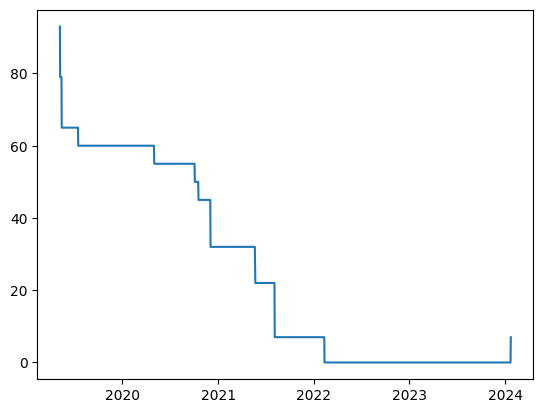

In [162]:
null_checks = [pl.col(col).is_null().cast(pl.UInt32) for col in final_df.columns]

# Sum the results of these expressions to count the number of nulls in each row
null_count_expr = sum(null_checks).alias("null_count")

# Add the null count as a new column to the original DataFrame
final_df = final_df.with_columns(null_count_expr)

# Display the DataFrame with the 'null_count' column
plt.plot(final_df["date"], final_df["null_count"])
plt.show()

In [164]:
# let's remove the rows with > 60 missing values
final_df = final_df.filter(pl.col("null_count") < 60)
final_df = final_df.drop("null_count")

In [151]:
# Create an expression to count nulls for each column
null_counts = [
    pl.col(column).is_null().sum().alias(column)
    for column in final_df.columns
    if column != "date"
]

# Apply the expressions to the DataFrame and collect the result
null_count_df = final_df.select(null_counts)

# Display the count of null values for each column
null_count_df.head()

BAT_totalBorrows,ETH_totalBorrows,DAI_totalBorrows,USDC_totalBorrows,ZRX_totalBorrows,WBTC_totalBorrows,USDT_totalBorrows,COMP_totalBorrows,UNI_totalBorrows,LINK_totalBorrows,TUSD_totalBorrows,SUSHI_totalBorrows,AAVE_totalBorrows,YFI_totalBorrows,BAT_borrowRate,ETH_borrowRate,DAI_borrowRate,USDC_borrowRate,ZRX_borrowRate,WBTC_borrowRate,USDT_borrowRate,COMP_borrowRate,UNI_borrowRate,LINK_borrowRate,TUSD_borrowRate,SUSHI_borrowRate,AAVE_borrowRate,YFI_borrowRate,BAT_supplyRate,ETH_supplyRate,DAI_supplyRate,USDC_supplyRate,ZRX_supplyRate,WBTC_supplyRate,USDT_supplyRate,COMP_supplyRate,UNI_supplyRate,…,ETH_mcap,YFI_mcap,UNI_mcap,COMP_mcap,TUSD_mcap,BAT_mcap,SUSHI_mcap,ZRX_mcap,date_right,WBTC_logreturn,USDC_logreturn,USDT_logreturn,DAI_logreturn,LINK_logreturn,AAVE_logreturn,ETH_logreturn,YFI_logreturn,UNI_logreturn,COMP_logreturn,TUSD_logreturn,BAT_logreturn,SUSHI_logreturn,ZRX_logreturn,WBTC_volatility,USDC_volatility,USDT_volatility,DAI_volatility,LINK_volatility,AAVE_volatility,ETH_volatility,YFI_volatility,UNI_volatility,COMP_volatility,TUSD_volatility,BAT_volatility,SUSHI_volatility,ZRX_volatility
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,70,360,529,515,746,745,820,820,820,0,0,0,0,0,70,360,529,515,746,745,820,820,820,0,0,0,0,0,70,360,529,515,…,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,7,7,7,7,7,7,7,7,7,7,7,7,7,7


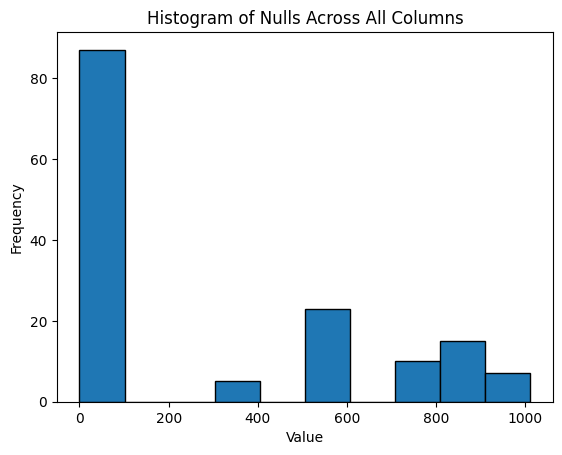

In [170]:
df_long = null_count_df.melt(
    id_vars=[], value_vars=null_count_df.columns, value_name="Values"
)

# Extract the values as a list or a numpy array
values = df_long["Values"].to_numpy()

# Plot a histogram of the values using Matplotlib
plt.hist(values, bins=10, edgecolor="k")  # Adjust the number of bins as needed
plt.title("Histogram of Nulls Across All Columns")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [172]:
# let's remove the columns with > 600 missing rows and fill the rest
df_long = df_long.filter(pl.col("Values") > 600)
cols_to_remove = df_long["variable"].to_list()
final_df = final_df.drop(cols_to_remove)
final_df = back_forward_fill(final_df)

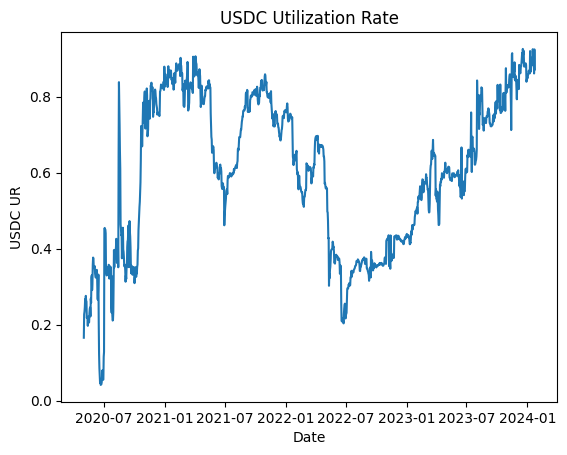

In [175]:
# We will try to predict the USDC utilization rate
plt.plot(final_df["date"], final_df["USDC_utilization_rate"])
plt.title("USDC Utilization Rate")
plt.xlabel("Date")
plt.ylabel("USDC UR")
plt.show()

In [193]:
# we want to predict the target variable on the next day
# let's shift the target variable by (-)1 day and remove the last row

final_df = final_df.with_columns(
    pl.col("USDC_utilization_rate").shift(-1).alias("USDC_utilization_rate")
)

final_df = final_df.drop_nulls()

final_df = final_df.sort("date")

# before attempting to predict, it would make sense to establish some benchmark against which we will evaluate the performance of the model
# as a simple heuristic of predicting the utilization rate, let's take a 7-day rolling average of the utilization rate
benchmark_df = final_df.with_columns(
    pl.col("USDC_utilization_rate").rolling_mean(7).alias("benchmark")
).select(["benchmark"])

X_df = final_df.drop(["USDC_utilization_rate", "date"])
Y_df = final_df.select(["USDC_utilization_rate"])

In [255]:
X_pandas = X_df.to_pandas()
Y_pandas = Y_df.to_pandas()
bench_pandas = benchmark_df.to_pandas()

# Split the data into training and testing sets based on the time order
# Assuming 80% for training and 20% for testing as an example
split_index = int(len(X_pandas) * 0.8)
X_train, X_test = X_pandas[:split_index], X_pandas[split_index:]
y_train, y_test = Y_pandas[:split_index], Y_pandas[split_index:]
y_benchmark = bench_pandas[split_index:]
benchmark_rmse = np.sqrt(mean_squared_error(y_test, y_benchmark["benchmark"]))
print(f"Benchmark RMSE: {benchmark_rmse}")

Benchmark RMSE: 0.027430737470998463


In [224]:
def plot_results(y_pred):
    plt.figure(figsize=(12, 8))
    plt.plot([i for i in range(len(y_test))], y_test, label="Actual")
    plt.plot([i for i in range(len(y_pred))], y_pred, label="Predicted")
    plt.plot(
        [i for i in range(len(y_benchmark))], y_benchmark["benchmark"], label="Benchmark"
    )
    plt.legend()
    plt.title("Model performance")
    plt.show()

## FF NN

In [265]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)  # Third hidden layer
        self.fc3 = nn.Linear(32, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Assuming X_train, y_train, X_test, y_test, and y_benchmark are already defined

X_train_tensor = torch.tensor(X_train.to_numpy().astype(np.float32))
y_train_tensor = torch.tensor(y_train.to_numpy().astype(np.float32).reshape(-1, 1))
X_test_tensor = torch.tensor(X_test.to_numpy().astype(np.float32))
y_test_tensor = torch.tensor(y_test.to_numpy().astype(np.float32).reshape(-1, 1))

# If y_benchmark is also a pandas DataFrame or Series, convert it similarly:
y_benchmark_tensor = torch.tensor(
    y_benchmark.to_numpy().astype(np.float32).reshape(-1, 1)
)


# Instantiate the model
input_size = X_train.shape[1]
model = SimpleNN(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100000  # Number of epochs to train for
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10000 == 0:  # Print loss every 10 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)
    test_rmse = torch.sqrt(test_loss)


print(f"Model RMSE: {test_rmse.item()}")

Epoch [1/100000], Loss: 5.05102997416575e+18
Epoch [10001/100000], Loss: 1495628513280.0
Epoch [20001/100000], Loss: 542094131200.0
Epoch [30001/100000], Loss: 14874596352.0
Epoch [40001/100000], Loss: 57329048.0
Epoch [50001/100000], Loss: 10048.603515625
Epoch [60001/100000], Loss: 0.19711892306804657
Epoch [70001/100000], Loss: 0.04159246385097504
Epoch [80001/100000], Loss: 0.04159246385097504
Epoch [90001/100000], Loss: 0.041592471301555634
Model RMSE: 5471.61328125


In [266]:
sample_input = torch.randn(1, X_train.shape[1], dtype=torch.float32)

# Specify the path where you want to save the ONNX model
onnx_model_path = "ff_nn.onnx"

# Export the model
torch.onnx.export(
    model,  # Model being exported
    sample_input,  # Model input (or a tuple for multiple inputs)
    onnx_model_path,  # Where to save the model
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,  # ONNX version to export the model to
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=["input"],  # Model's input names
    output_names=["output"],  # Model's output names
    dynamic_axes={
        "input": {0: "batch_size"},  # Variable length axes
        "output": {0: "batch_size"},
    },
)

print(f"Model has been converted to ONNX and saved to {onnx_model_path}")

Model has been converted to ONNX and saved to ff_nn.onnx


In [267]:
# Load the ONNX model
sess = rt.InferenceSession(onnx_model_path)

# Get the name of the input layer
input_name = sess.get_inputs()[0].name

# Ensure X_test is a NumPy array and its dtype is float32
X_test_np = (
    X_test.to_numpy().astype(np.float32)
    if isinstance(X_test, pd.DataFrame)
    else X_test.astype(np.float32)
)

# Predict using the ONNX model, providing the input as a NumPy array
pred_onnx = sess.run(None, {input_name: X_test_np})[0]
onnx_rmse = np.sqrt(mean_squared_error(y_test, pred_onnx))
print(f"ONNX RMSE: {onnx_rmse}")
assert abs((test_rmse.item() / onnx_rmse) - 1) < 1e-6

ONNX RMSE: 5471.610405566203


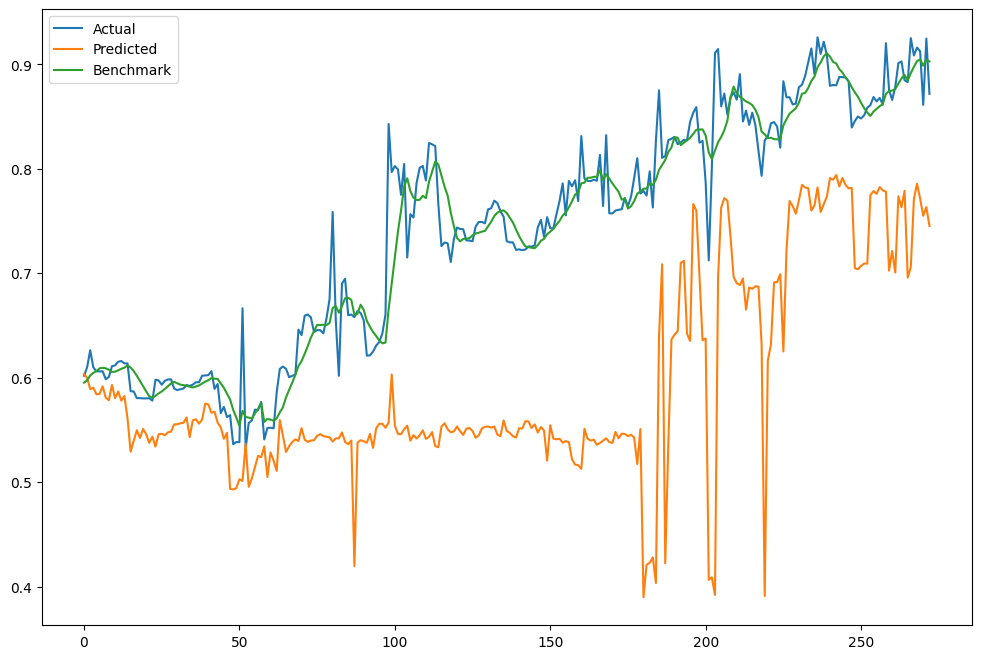

In [208]:
plot_results(y_pred_tensor)